<a href="https://colab.research.google.com/github/wmalevich/ds_course/blob/main/hw_2(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

In [ ]:
!pip install -q opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download('https://www.kaggle.com/datasets/joebeachcapital/57651-spotify-songs')
df = pd.read_csv('/content/57651-spotify-songs/Spotify Million Song Dataset_exported.csv')

Skipping, found downloaded files in "./57651-spotify-songs" (use force=True to force download)


In [ ]:
# Создаем объект Tokenizer для токенизации текста
tokenizer = Tokenizer()

# Получаем подмножество текстовых данных из столбца "text" первых 200 строк из DataFrame `df`
text_subset_200 = df["text"][:200]

# Инициализируем список для хранения текстов песен
song_texts = []

# Проходимся по каждой строке текста в подмножестве и преобразуем его в список слов
for text in text_subset_200:
    # Приводим строку к нижнему регистру, удаляем лишние пробелы и разбиваем на слова
    song_text = text.lower().replace("  ", "").split("\n")
    # Фильтруем пустые строки
    song_text = [word for word in song_text if word != ""]
    # Добавляем список слов в список текстов песен
    song_texts.append(song_text)

# Собираем все слова из текстов в один список, формируя корпус
corpus = [word for song_text in song_texts for word in song_text]

# Обучаем токенизатор на корпусе для преобразования слов в уникальные целочисленные идентификаторы
tokenizer.fit_on_texts(corpus)

# Вычисляем общее количество уникальных слов в корпусе для последующего использования в модели
total_words = len(tokenizer.word_index) + 1

0      Look at her face, it's a wonderful face  \nAnd...
1      Take it easy with me, please  \nTouch me gentl...
2      I'll never know why I had to go  \nWhy I had t...
3      Making somebody happy is a question of give an...
4      Making somebody happy is a question of give an...
                             ...                        
195    Get yourself cooler, lay yourself low  \nCoinc...
196    It's deep insignus  \nThat knows me well  \nIt...
197    Blues hearted lady sleepy was she,  \nLove for...
198    I was a city boy  \nCaught up in a city way  \...
199    Shame shame shame on you Miss Roxy  \nShame sh...
Name: text, Length: 200, dtype: object


In [ ]:
# Создаем пустой список для хранения последовательностей токенов
input_sequences = []

# Проходимся по каждой строке текста в корпусе
for line in corpus:
    # Преобразуем текущую строку текста в последовательность токенов
    token_list = tokenizer.texts_to_sequences([line])[0]

    # Создаем n-граммы для текущей строки текста
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]  # Формируем последовательность, начиная с первого слова и последовательно добавляя по одному слову
        input_sequences.append(n_gram_sequence)  # Добавляем полученную последовательность в список

# Печатаем последний элемент из списка token_list
print(token_list)

# Вычисляем максимальную длину последовательности в input_sequences
max_sequence_len = max([len(x) for x in input_sequences])

# Преобразуем список input_sequences в numpy array и дополняем нулями до максимальной длины
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Выводим преобразованный input_sequences
print(input_sequences)

# Создаем массивы xs и labels
xs, labels = input_sequences[:, :-1], input_sequences[:, -1]

# Создаем трехмерный массив ys для хранения меток в формате one-hot encoding
ys = np.zeros((len(xs), max_sequence_len, total_words), dtype=np.bool_)

# Проходимся по каждой последовательности в xs
for i, sequence in enumerate(xs):
    # Проходимся по каждому токену в последовательности
    for j, word_index in enumerate(sequence):
        # Устанавливаем соответствующий элемент вектора one-hot encoding в 1
        ys[i, j, word_index] = 1

[149, 149, 149, 19, 35, 3, 183, 101, 56, 101, 56, 56]
[[  0   0   0 ...   0 108  60]
 [  0   0   0 ... 108  60  88]
 [  0   0   0 ...  60  88 199]
 ...
 [  0   0   0 ... 101  56 101]
 [  0   0   0 ...  56 101  56]
 [  0   0   0 ... 101  56  56]]


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Определение гиперпараметров модели
latent_dim = 128  # Размерность скрытых состояний LSTM

# Создание кодирующей LSTM
encoder_inputs = tf.keras.layers.Input(shape=(max_sequence_len-1,))
encoder_embedding = tf.keras.layers.Embedding(total_words, latent_dim, input_length=max_sequence_len-1)(encoder_inputs)
encoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Создание декодирующей LSTM с вниманием
decoder_inputs = tf.keras.layers.Input(shape=(max_sequence_len-1,))
decoder_embedding = tf.keras.layers.Embedding(total_words, latent_dim, input_length=max_sequence_len-1)(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Добавление слоя Attention
attention_layer = tf.keras.layers.Attention()
context_vector = attention_layer([decoder_outputs, encoder_outputs])

# Объединение контекстного вектора с выходом декодера
decoder_combined_context = tf.keras.layers.Concatenate(axis=-1)([context_vector, decoder_outputs])

# Полносвязанный слой для получения предсказаний
decoder_dense = tf.keras.layers.Dense(total_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# Создание модели seq2seq
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Подготовка меток
ys_corrected = ys[:, :-1, :]

from sklearn.model_selection import train_test_split

# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(xs, ys_corrected, test_size=0.2, random_state=42)

# Обучение модели на обучающих данных
history = model.fit([x_train, x_train], y_train, epochs=5, batch_size=32, verbose=1, validation_data=([x_test, x_test], y_test))

# Обучение модели
#history = model.fit([xs, xs], ys_corrected, epochs=10, verbose=1)

Epoch 1/5
1029/1029 [==============================] - 226s 211ms/step - loss: 1.0896 - accuracy: 0.8417 - val_loss: 0.5348 - val_accuracy: 0.9172
Epoch 2/5
1029/1029 [==============================] - 212s 206ms/step - loss: 0.3340 - accuracy: 0.9511 - val_loss: 0.2056 - val_accuracy: 0.9733
Epoch 3/5
1029/1029 [==============================] - 209s 203ms/step - loss: 0.1333 - accuracy: 0.9829 - val_loss: 0.0968 - val_accuracy: 0.9884
Epoch 4/5
1029/1029 [==============================] - 211s 205ms/step - loss: 0.0582 - accuracy: 0.9930 - val_loss: 0.0508 - val_accuracy: 0.9941
Epoch 5/5
1029/1029 [==============================] - 211s 205ms/step - loss: 0.0255 - accuracy: 0.9972 - val_loss: 0.0293 - val_accuracy: 0.9967


In [ ]:
'''import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Предположим, что у вас уже есть подготовленные данные и токенизатор

# Определение гиперпараметров модели
latent_dim = 128  # Размерность скрытых состояний LSTM

# Создание кодирующей LSTM
encoder_inputs = tf.keras.layers.Input(shape=(max_sequence_len-1,))
encoder_embedding = tf.keras.layers.Embedding(total_words, latent_dim, input_length=max_sequence_len-1)(encoder_inputs)
encoder_lstm = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Создание декодирующей LSTM
decoder_inputs = tf.keras.layers.Input(shape=(max_sequence_len-1,))
decoder_embedding_layer = tf.keras.layers.Embedding(total_words, latent_dim, input_length=max_sequence_len-1)
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(total_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Создание модели seq2seq
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ys_corrected = ys[:, :-1, :]

# Обучение модели
history = model.fit([xs, xs], ys_corrected, epochs=10, verbose=1)'''

Epoch 1/10
332/332 [==============================] - 14s 32ms/step - loss: 1.6931 - accuracy: 0.7894
Epoch 2/10
332/332 [==============================] - 3s 9ms/step - loss: 1.0282 - accuracy: 0.8245
Epoch 3/10
332/332 [==============================] - 3s 10ms/step - loss: 0.7127 - accuracy: 0.8807
Epoch 4/10
332/332 [==============================] - 2s 7ms/step - loss: 0.5091 - accuracy: 0.9211
Epoch 5/10
332/332 [==============================] - 2s 7ms/step - loss: 0.3747 - accuracy: 0.9429
Epoch 6/10
332/332 [==============================] - 3s 8ms/step - loss: 0.2737 - accuracy: 0.9618
Epoch 7/10
332/332 [==============================] - 3s 8ms/step - loss: 0.1983 - accuracy: 0.9736
Epoch 8/10
332/332 [==============================] - 3s 9ms/step - loss: 0.1443 - accuracy: 0.9808
Epoch 9/10
332/332 [==============================] - 3s 8ms/step - loss: 0.1043 - accuracy: 0.9865
Epoch 10/10
332/332 [==============================] - 2s 7ms/step - loss: 0.0744 - accuracy: 0.9

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Определение гиперпараметров модели
latent_dim = 128  # Размерность скрытых состояний LSTM

# Создание кодирующей LSTM
encoder_inputs = tf.keras.layers.Input(shape=(max_sequence_len-1,))
encoder_embedding = tf.keras.layers.Embedding(total_words, latent_dim, input_length=max_sequence_len-1)(encoder_inputs)
encoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Создание декодирующей LSTM с вниманием
decoder_inputs = tf.keras.layers.Input(shape=(max_sequence_len-1,))
decoder_embedding = tf.keras.layers.Embedding(total_words, latent_dim, input_length=max_sequence_len-1)(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Добавление слоя Attention
attention_layer = tf.keras.layers.Attention()
context_vector = attention_layer([decoder_outputs, encoder_outputs])

# Объединение контекстного вектора с выходом декодера
decoder_combined_context = tf.keras.layers.Concatenate(axis=-1)([context_vector, decoder_outputs])

# Добавление слоя отсева
decoder_dropout = tf.keras.layers.Dropout(0.5)  # Указываем вероятность "выключения" нейронов
decoder_outputs = decoder_dropout(decoder_combined_context)

# Полносвязанный слой для получения предсказаний
decoder_dense = tf.keras.layers.Dense(total_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Создание модели seq2seq
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Подготовка меток
ys_corrected = ys[:, :-1, :]

from sklearn.model_selection import train_test_split

# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(xs, ys_corrected, test_size=0.2, random_state=42)

# Обучение модели на обучающих данных
history = model.fit([x_train, x_train], y_train, epochs=5, batch_size=64, verbose=1, validation_data=([x_test, x_test], y_test))

# Обучение модели
#history = model.fit([xs, xs], ys_corrected, epochs=10, verbose=1)

Epoch 1/5
515/515 [==============================] - 215s 397ms/step - loss: 1.4411 - accuracy: 0.8065 - val_loss: 0.9512 - val_accuracy: 0.8392
Epoch 2/5
515/515 [==============================] - 191s 371ms/step - loss: 0.7092 - accuracy: 0.8794 - val_loss: 0.4832 - val_accuracy: 0.9285
Epoch 3/5
515/515 [==============================] - 184s 358ms/step - loss: 0.3950 - accuracy: 0.9380 - val_loss: 0.2867 - val_accuracy: 0.9605
Epoch 4/5
515/515 [==============================] - 172s 334ms/step - loss: 0.2499 - accuracy: 0.9629 - val_loss: 0.1867 - val_accuracy: 0.9762
Epoch 5/5
515/515 [==============================] - 172s 334ms/step - loss: 0.1670 - accuracy: 0.9768 - val_loss: 0.1264 - val_accuracy: 0.9850


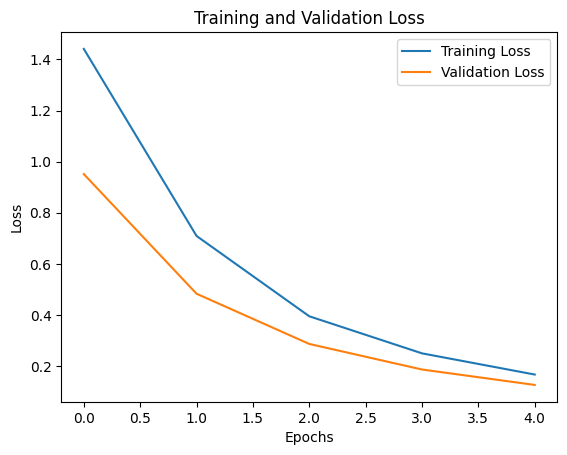

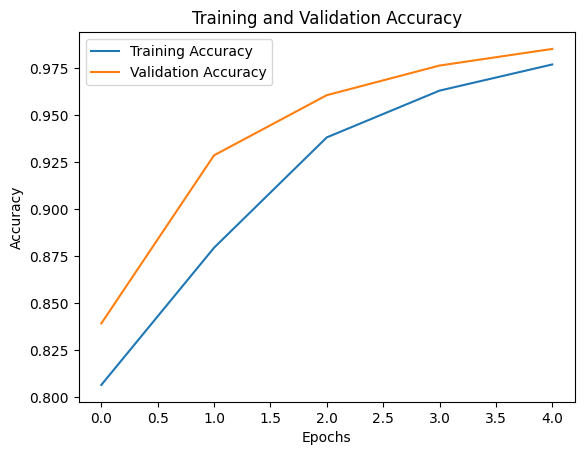

In [ ]:
import matplotlib.pyplot as plt

# Построение графика потерь на обучающей и тестовой выборках
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Построение графика точности на обучающей и тестовой выборках
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Начальная фраза
seed_text = "look at her face it's a wonderful face"
# Количество слов для генерации
next_words = 5

# Генерация текста
for _ in range(next_words):
    # Преобразование начальной фразы в последовательность токенов
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Добавление заполнения до максимальной длины последовательности
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Предсказание следующего слова
    predicted = np.argmax(model.predict([token_list, token_list]), axis=-1)
    # Извлечение предсказанных слов из индексов
    output_words = []
    for predicted_index in predicted[0]:
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_words.append(word)
                break
    # Добавление предсказанных слов к последовательности
    seed_text += " " + " ".join(output_words)

# Вывод сгенерированного текста
print(seed_text)

1/1 [==============================] - 0s 28ms/step
look at her face it's a wonderful face look at her face it's a memory face look at her face it's a memory face look at her face it's a memory chance to air way got their got hard got to a be got on got up hard hard know know to air way got their got hard got to to my got on got on on on to to to air way got their got hard got to to my got on got on on on to to
